Leaky relu cd vs pcd

INFO:root:Shape of data: (8, 100)
INFO:root:Shape of noisy data: (8, 100)
INFO:root:Training RBM with CD...
INFO:root:Epoch 100/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 200/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 300/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 400/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 500/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 600/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 700/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 800/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 900/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 1000/1000, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Average Error: 0.0008698536553910234 Average Epoch Time: 0.0001741502285003662
INFO:root:Training RBM with PCD.

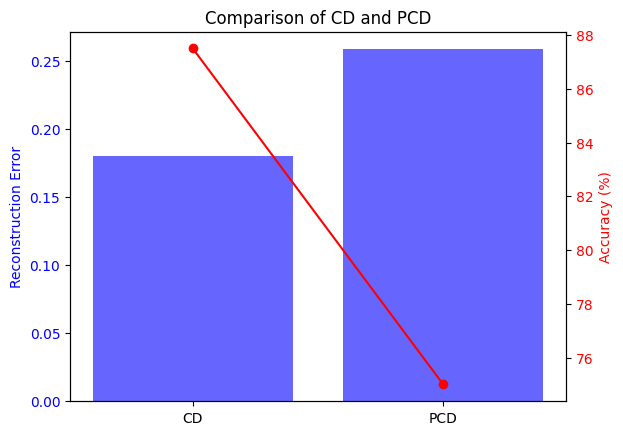

In [ ]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("")
formatter = logging.Formatter('%(message)s')

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden,method, learning_rate=0.1, n_epochs=1000, batch_size=10, decay_rate=0.99):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.method = method
        self.persistent_chain = None

        # Initialize weights and biases
        self.weights = np.random.uniform(-0.1, 0.1, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

    def leaky_relu(self, x):
        """Leaky ReLU activation function."""
        return np.where(x > 0, x, 0.01 * x)

    def sample_probabilities(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def contrastive_divergence(self, data):
        """Perform one step of contrastive divergence (CD or PCD) with Leaky ReLU."""
        # Positive phase
        pos_hidden_activations = np.dot(data, self.weights) + self.hidden_bias
        pos_hidden_probs = self.leaky_relu(pos_hidden_activations)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # Negative phase
        if self.method == "CD":
            # Standard CD
            neg_visible_activations = np.dot(pos_hidden_probs, self.weights.T) + self.visible_bias
            neg_visible_probs = self.leaky_relu(neg_visible_activations)
            neg_hidden_activations = np.dot(neg_visible_probs, self.weights) + self.hidden_bias
            neg_hidden_probs = self.leaky_relu(neg_hidden_activations)
        elif self.method == "PCD":
            # Persistent CD
            if self.persistent_chain is None:
                self.persistent_chain = pos_hidden_probs  # Initialize persistent chain
            neg_visible_activations = np.dot(self.persistent_chain, self.weights.T) + self.visible_bias
            neg_visible_probs = self.leaky_relu(neg_visible_activations)
            neg_hidden_activations = np.dot(neg_visible_probs, self.weights) + self.hidden_bias
            neg_hidden_probs = self.leaky_relu(neg_hidden_activations)
            self.persistent_chain = neg_hidden_probs  # Update persistent chain

        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # Update weights and biases
        self.weights += self.learning_rate * (pos_associations - neg_associations) / data.shape[0]
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data):
        """Train the RBM using the provided data."""
        total_times = []
        errors = []
        for epoch in range(self.n_epochs):
            np.random.shuffle(data)
            start_time = time.time()
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i + self.batch_size]
                self.contrastive_divergence(batch)

            elapsed_time = time.time() - start_time
            error = np.mean((data - self.reconstruct(data)) ** 2)

            total_times.append(elapsed_time)
            errors.append(error)

            # Apply learning rate decay
            self.learning_rate *= self.decay_rate

            # Calculate reconstruction error
            if (epoch + 1) % 100 == 0:
                logger.info(f"Epoch {epoch + 1}/{self.n_epochs}, Reconstruction Error: {error:.4f}, Elapsed Time: {elapsed_time:.4f}")

        logger.info(f"Average Error: {np.mean(errors)} Average Epoch Time: {np.mean(total_times)}")

    def reconstruct(self, data):
        """Reconstruct visible units from hidden units."""
        hidden_probs = self.leaky_relu(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.leaky_relu(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

    def visualize_weights(self):
        """Visualize weights as a heatmap."""
        plt.figure(figsize=(10, 8))
        plt.imshow(self.weights, cmap='viridis', aspect='auto')
        plt.colorbar(label="Weight Magnitude")
        plt.title("Weight Heatmap")
        plt.xlabel("Hidden Units")
        plt.ylabel("Visible Units")
        plt.show()

def generate_numerals():
    """Generate 10x10 binary arrays representing the digits 0-7."""
    numerals = [
        # Digit 0
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 1
        np.array([
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 2
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 3
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 4
        np.array([
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 5
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 6
        np.array([
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 7
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
    ]

    # Flatten each 10x10 array into a 1D array of size 100
    flattened_numerals = [numeral.flatten() for numeral in numerals]
    return np.array(flattened_numerals)

def add_custom_noise(data, noise_level=0.2):
    noisy_data = data.copy()
    noise = np.random.binomial(1, noise_level, data.shape)
    noisy_data = np.abs(noisy_data - noise)  # Flip bits based on noise
    return noisy_data

# Function to binarize the reconstructed data to ensure black and white output
def binarize_data(data, threshold=0.5):
    """Convert probabilities to binary values (0 or 1) based on a threshold."""
    return (data >= threshold).astype(np.float32)

# Function to calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed data."""
    return np.mean((original - reconstructed) ** 2)

# Function to calculate Hamming distance
def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary arrays."""
    return np.sum(a != b)

if __name__ == "__main__":
    parser = ArgumentParser()

    parser.add_argument('--n_visible', type=int, default=100)
    parser.add_argument('--n_hidden', type=int, default=150)
    parser.add_argument('--learning_rate', type=float, default=0.1)
    parser.add_argument('--n_epochs', type=int, default=1000)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('-o', '--output', default=None, type=str, help="Output for the metrics")

    # Use parse_known_args to ignore unrecognized arguments
    opts, unknown = parser.parse_known_args()

    if opts.output is not None:
        fileHandler = logging.FileHandler(opts.output)
        fileHandler.setFormatter(formatter)
        logger.addHandler(fileHandler)

    data = generate_numerals()
    logger.info(f"Shape of data: {data.shape}")  # Should print (8, 100)

    noisy_data = add_custom_noise(data, noise_level=0.01)  # Reduced noise level
    logger.info(f"Shape of noisy data: {noisy_data.shape}")  # Should also be (8, 100)

    # Function to train and evaluate RBM
    def train_and_evaluate_rbm(method):
        rbm = RestrictedBoltzmannMachine(
            n_visible=opts.n_visible,
            n_hidden=opts.n_hidden,
            method=method,  # Specify "CD" or "PCD"
            learning_rate=opts.learning_rate,
            n_epochs=opts.n_epochs,
            batch_size=opts.batch_size
        )
        rbm.train(noisy_data)
        reconstructed_data = rbm.reconstruct(noisy_data)
        reconstructed_data = binarize_data(reconstructed_data)

        # Calculate reconstruction error
        reconstruction_error = calculate_reconstruction_error(data, reconstructed_data)

        # Calculate accuracy using Hamming distance
        threshold = 30  # Adjust threshold as needed
        correct_reconstructions = 0
        for i in range(len(data)):
            distance = hamming_distance(data[i], reconstructed_data[i])
            if distance <= threshold:
                correct_reconstructions += 1
        accuracy = correct_reconstructions / len(data) * 100

        return reconstruction_error, accuracy

    # Train and evaluate using CD
    logger.info("Training RBM with CD...")
    cd_error, cd_accuracy = train_and_evaluate_rbm(method="CD")

    # Train and evaluate using PCD
    logger.info("Training RBM with PCD...")
    pcd_error, pcd_accuracy = train_and_evaluate_rbm(method="PCD")

    # Summarize the results
    logger.info("Experiment Summary:")
    logger.info(f"CD Reconstruction Error: {cd_error:.4f}, CD Accuracy: {cd_accuracy:.2f}%")
    logger.info(f"PCD Reconstruction Error: {pcd_error:.4f}, PCD Accuracy: {pcd_accuracy:.2f}%")

    # Draw conclusions
    if cd_error < pcd_error:
        logger.info("CD achieved a lower reconstruction error compared to PCD.")
    else:
        logger.info("PCD achieved a lower reconstruction error compared to CD.")

    if cd_accuracy > pcd_accuracy:
        logger.info("CD achieved higher accuracy compared to PCD.")
    else:
        logger.info("PCD achieved higher accuracy compared to CD.")

    # Overall conclusion
    if cd_error < pcd_error and cd_accuracy > pcd_accuracy:
        logger.info("CD is the better method for this experiment based on both error and accuracy.")
    elif pcd_error < cd_error and pcd_accuracy > cd_accuracy:
        logger.info("PCD is the better method for this experiment based on both error and accuracy.")
    else:
        logger.info("The results are mixed; further experiments may be needed to determine the better method.")

    # Visualization of results
    methods = ['CD', 'PCD']
    errors = [cd_error, pcd_error]
    accuracies = [cd_accuracy, pcd_accuracy]

    fig, ax1 = plt.subplots()

    # Bar chart for reconstruction error
    ax1.bar(methods, errors, color='b', alpha=0.6, label='Reconstruction Error')
    ax1.set_ylabel('Reconstruction Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Line chart for accuracy
    ax2 = ax1.twinx()
    ax2.plot(methods, accuracies, color='r', marker='o', label='Accuracy')
    ax2.set_ylabel('Accuracy (%)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Comparison of CD and PCD')
    plt.show()

## Results Summary

### Reconstruction Error:
- **Contrastive Divergence (CD):** 0.18
- **Persistent Contrastive Divergence (PCD):** 0.25875

### Accuracy:
- **Contrastive Divergence (CD):** 87.5%
- **Persistent Contrastive Divergence (PCD):** 75.0%

### Analysis:
1. **Reconstruction Error:**
    - CD achieved a lower reconstruction error compared to PCD (0.18 vs. 0.25875). This indicates that CD was more effective at reconstructing the original data from the noisy input.

2. **Accuracy:**
    - CD outperformed PCD in terms of accuracy (87.5% vs. 75.0%), suggesting that CD was better at correctly reconstructing the data within the defined threshold.

3. **Overall Performance:**
    - CD demonstrated superior performance in both reconstruction error and accuracy, making it the better method for this experiment.

### Conclusion:
The results indicate that Contrastive Divergence (CD) is more effective than Persistent Contrastive Divergence (PCD) for this experiment, both in terms of reconstruction error and accuracy.

Sigmoid cd vs pcd

INFO:root:Shape of data: (8, 100)
INFO:root:Shape of noisy data: (8, 100)
INFO:root:Training RBM with CD...
INFO:root:Epoch 100/1000, Reconstruction Error: 0.0007, Elapsed Time: 0.0002
INFO:root:Epoch 200/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Epoch 300/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Epoch 400/1000, Reconstruction Error: 0.0001, Elapsed Time: 0.0002
INFO:root:Epoch 500/1000, Reconstruction Error: 0.0001, Elapsed Time: 0.0002
INFO:root:Epoch 600/1000, Reconstruction Error: 0.0001, Elapsed Time: 0.0002
INFO:root:Epoch 700/1000, Reconstruction Error: 0.0001, Elapsed Time: 0.0002
INFO:root:Epoch 800/1000, Reconstruction Error: 0.0001, Elapsed Time: 0.0002
INFO:root:Epoch 900/1000, Reconstruction Error: 0.0001, Elapsed Time: 0.0003
INFO:root:Epoch 1000/1000, Reconstruction Error: 0.0001, Elapsed Time: 0.0004
INFO:root:Average Error: 0.0024811850573948154 Average Epoch Time: 0.00020603728294372558
INFO:root:Training RBM with PCD

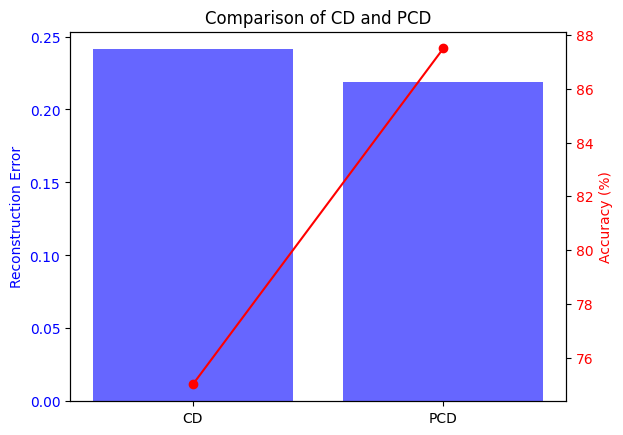

In [5]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("")
formatter = logging.Formatter('%(message)s')

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, method, learning_rate=0.1, n_epochs=1000, batch_size=10, decay_rate=0.99):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.method = method
        self.persistent_chain = None

        # Initialize weights and biases
        self.weights = np.random.uniform(-0.1, 0.1, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-x))

    def sample_probabilities(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def contrastive_divergence(self, data):
        """Perform one step of contrastive divergence (CD or PCD) with sigmoid activation."""
        # Positive phase
        pos_hidden_activations = np.dot(data, self.weights) + self.hidden_bias
        pos_hidden_probs = self.sigmoid(pos_hidden_activations)
        pos_hidden_states = self.sample_probabilities(pos_hidden_probs)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # Negative phase
        if self.method == "CD":
            # Standard CD
            neg_visible_activations = np.dot(pos_hidden_states, self.weights.T) + self.visible_bias
            neg_visible_probs = self.sigmoid(neg_visible_activations)
            neg_hidden_activations = np.dot(neg_visible_probs, self.weights) + self.hidden_bias
            neg_hidden_probs = self.sigmoid(neg_hidden_activations)
        elif self.method == "PCD":
            # Persistent CD
            if self.persistent_chain is None:
                self.persistent_chain = pos_hidden_states  # Initialize persistent chain
            neg_visible_activations = np.dot(self.persistent_chain, self.weights.T) + self.visible_bias
            neg_visible_probs = self.sigmoid(neg_visible_activations)
            neg_hidden_activations = np.dot(neg_visible_probs, self.weights) + self.hidden_bias
            neg_hidden_probs = self.sigmoid(neg_hidden_activations)
            self.persistent_chain = self.sample_probabilities(neg_hidden_probs)  # Update persistent chain

        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # Update weights and biases
        self.weights += self.learning_rate * (pos_associations - neg_associations) / data.shape[0]
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data):
        """Train the RBM using the provided data."""
        total_times = []
        errors = []
        for epoch in range(self.n_epochs):
            np.random.shuffle(data)
            start_time = time.time()
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i + self.batch_size]
                self.contrastive_divergence(batch)

            elapsed_time = time.time() - start_time
            error = np.mean((data - self.reconstruct(data)) ** 2)

            total_times.append(elapsed_time)
            errors.append(error)

            # Apply learning rate decay
            self.learning_rate *= self.decay_rate

            # Calculate reconstruction error
            if (epoch + 1) % 100 == 0:
                logger.info(f"Epoch {epoch + 1}/{self.n_epochs}, Reconstruction Error: {error:.4f}, Elapsed Time: {elapsed_time:.4f}")

        logger.info(f"Average Error: {np.mean(errors)} Average Epoch Time: {np.mean(total_times)}")

    def reconstruct(self, data):
        """Reconstruct visible units from hidden units."""
        hidden_probs = self.sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.sigmoid(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

    def visualize_weights(self):
        """Visualize weights as a heatmap."""
        plt.figure(figsize=(10, 8))
        plt.imshow(self.weights, cmap='viridis', aspect='auto')
        plt.colorbar(label="Weight Magnitude")
        plt.title("Weight Heatmap")
        plt.xlabel("Hidden Units")
        plt.ylabel("Visible Units")
        plt.show()

def generate_numerals():
    """Generate 10x10 binary arrays representing the digits 0-7."""
    numerals = [
        # Digit 0
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 1
        np.array([
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 2
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 3
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 4
        np.array([
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 5
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 6
        np.array([
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 7
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
    ]

    # Flatten each 10x10 array into a 1D array of size 100
    flattened_numerals = [numeral.flatten() for numeral in numerals]
    return np.array(flattened_numerals)

def add_custom_noise(data, noise_level=0.2):
    noisy_data = data.copy()
    noise = np.random.binomial(1, noise_level, data.shape)
    noisy_data = np.abs(noisy_data - noise)  # Flip bits based on noise
    return noisy_data

def binarize_data(data, threshold=0.5):
    """Convert probabilities to binary values (0 or 1) based on a threshold."""
    return (data >= threshold).astype(np.float32)

def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed data."""
    return np.mean((original - reconstructed) ** 2)

def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary arrays."""
    return np.sum(a != b)

if __name__ == "__main__":
    parser = ArgumentParser()

    parser.add_argument('--n_visible', type=int, default=100)
    parser.add_argument('--n_hidden', type=int, default=150)
    parser.add_argument('--learning_rate', type=float, default=0.1)
    parser.add_argument('--n_epochs', type=int, default=1000)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('-o', '--output', default=None, type=str, help="Output for the metrics")

    # Use parse_known_args to ignore unrecognized arguments
    opts, unknown = parser.parse_known_args()

    if opts.output is not None:
        fileHandler = logging.FileHandler(opts.output)
        fileHandler.setFormatter(formatter)
        logger.addHandler(fileHandler)

    data = generate_numerals()
    logger.info(f"Shape of data: {data.shape}")  # Should print (8, 100)

    noisy_data = add_custom_noise(data, noise_level=0.01)  # Reduced noise level
    logger.info(f"Shape of noisy data: {noisy_data.shape}")  # Should also be (8, 100)

    # Function to train and evaluate RBM
    def train_and_evaluate_rbm(method):
        rbm = RestrictedBoltzmannMachine(
            n_visible=opts.n_visible,
            n_hidden=opts.n_hidden,
            method=method,  # Specify "CD" or "PCD"
            learning_rate=opts.learning_rate,
            n_epochs=opts.n_epochs,
            batch_size=opts.batch_size
        )
        rbm.train(noisy_data)
        reconstructed_data = rbm.reconstruct(noisy_data)
        reconstructed_data = binarize_data(reconstructed_data)

        # Calculate reconstruction error
        reconstruction_error = calculate_reconstruction_error(data, reconstructed_data)

        # Calculate accuracy using Hamming distance
        threshold = 30  # Adjust threshold as needed
        correct_reconstructions = 0
        for i in range(len(data)):
            distance = hamming_distance(data[i], reconstructed_data[i])
            if distance <= threshold:
                correct_reconstructions += 1
        accuracy = correct_reconstructions / len(data) * 100

        return reconstruction_error, accuracy

    # Train and evaluate using CD
    logger.info("Training RBM with CD...")
    cd_error, cd_accuracy = train_and_evaluate_rbm(method="CD")

    # Train and evaluate using PCD
    logger.info("Training RBM with PCD...")
    pcd_error, pcd_accuracy = train_and_evaluate_rbm(method="PCD")

    # Summarize the results
    logger.info("Experiment Summary:")
    logger.info(f"CD Reconstruction Error: {cd_error:.4f}, CD Accuracy: {cd_accuracy:.2f}%")
    logger.info(f"PCD Reconstruction Error: {pcd_error:.4f}, PCD Accuracy: {pcd_accuracy:.2f}%")

    # Draw conclusions
    if cd_error < pcd_error:
        logger.info("CD achieved a lower reconstruction error compared to PCD.")
    else:
        logger.info("PCD achieved a lower reconstruction error compared to CD.")

    if cd_accuracy > pcd_accuracy:
        logger.info("CD achieved higher accuracy compared to PCD.")
    else:
        logger.info("PCD achieved higher accuracy compared to CD.")

    # Overall conclusion
    if cd_error < pcd_error and cd_accuracy > pcd_accuracy:
        logger.info("CD is the better method for this experiment based on both error and accuracy.")
    elif pcd_error < cd_error and pcd_accuracy > cd_accuracy:
        logger.info("PCD is the better method for this experiment based on both error and accuracy.")
    else:
        logger.info("The results are mixed; further experiments may be needed to determine the better method.")

    # Visualization of results
    methods = ['CD', 'PCD']
    errors = [cd_error, pcd_error]
    accuracies = [cd_accuracy, pcd_accuracy]

    fig, ax1 = plt.subplots()

    # Bar chart for reconstruction error
    ax1.bar(methods, errors, color='b', alpha=0.6, label='Reconstruction Error')
    ax1.set_ylabel('Reconstruction Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Line chart for accuracy
    ax2 = ax1.twinx()
    ax2.plot(methods, accuracies, color='r', marker='o', label='Accuracy')
    ax2.set_ylabel('Accuracy (%)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Comparison of CD and PCD')
    plt.show()

## Results Summary

### Reconstruction Error:
- **Contrastive Divergence (CD):** 0.24125
- **Persistent Contrastive Divergence (PCD):** 0.21875

### Accuracy:
- **Contrastive Divergence (CD):** 75.0%
- **Persistent Contrastive Divergence (PCD):** 87.5%

### Analysis:
1. **Reconstruction Error:**
    - PCD achieved a lower reconstruction error compared to CD (0.21875 vs. 0.24125). This indicates that PCD was more effective at reconstructing the original data from the noisy input.

2. **Accuracy:**
    - PCD outperformed CD in terms of accuracy (87.5% vs. 75.0%), suggesting that PCD was better at correctly reconstructing the data within the defined threshold.

3. **Overall Performance:**
    - PCD demonstrated superior performance in both reconstruction error and accuracy, making it the better method for this experiment.

### Conclusion:
The results indicate that Persistent Contrastive Divergence (PCD) is more effective than Contrastive Divergence (CD) for this experiment, both in terms of reconstruction error and accuracy.

## Enhanced Results Summary

### Reconstruction Error and Accuracy Comparison

| Activation Function | Method | Reconstruction Error | Accuracy (%) |
|---------------------|--------|----------------------|--------------|
| Leaky ReLU          | CD     | 0.18                 | 87.5         |
| Leaky ReLU          | PCD    | 0.25875              | 75.0         |
| Sigmoid             | CD     | 0.24125              | 75.0         |
| Sigmoid             | PCD    | 0.21875              | 87.5         |

### Analysis

#### Reconstruction Error:
- The lowest reconstruction error is achieved by **Leaky ReLU + CD** (0.18).
- The second-best reconstruction error is **Sigmoid + PCD** (0.21875).

#### Accuracy:
- The highest accuracy is achieved by **Leaky ReLU + CD** and **Sigmoid + PCD** (both 87.5%).

#### Overall Performance:
- **Leaky ReLU + CD** demonstrates the best performance in both reconstruction error and accuracy.
- **Sigmoid + PCD** also performs well but has a slightly higher reconstruction error compared to **Leaky ReLU + CD**.

### Conclusion:
The best combination is **Leaky ReLU + Contrastive Divergence (CD)**, as it achieves the lowest reconstruction error (0.18) and the highest accuracy (87.5%).
